Install all needed libraries


In [1]:
pip install beautifulsoup4

     |████████████████████████████████| 112kB 30.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lxml

     |████████████████████████████████| 5.8MB 7.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

In [4]:
import csv
from bs4 import BeautifulSoup

Request URL via Beautiful Soup that contains the Austin, TX zip code data.  Craft brewery data will be downloaded via FourSquare

In [5]:
source=requests.get('http://www.city-data.com/zipmaps/Austin-Texas.html').text

In [6]:
soup=BeautifulSoup(source, 'lxml')

Pull out the list of zip codes from the website and write to a csv file

In [7]:
csv_file=open('zip_codes','w')
csv_writer=csv.writer(csv_file)
csv_writer.writerow(['Zip Codes'])

div=soup.find(class_="zip-codes")
for article in div.find_all('a'):
    article=article.get('href')
    #print(article)
    csv_writer.writerow([article])
    
csv_file.close()

  

Read in CSV file containing the Austin, TX Zip Codes to Dataframe and clean data

In [8]:
zip_df = pd.read_csv('zip_codes.csv.txt')
zip_df['Zip Codes'] = zip_df['Zip Codes'].str.replace('#', '')
zip_df.head(5)

,Zip Codes
0,78610
1,78613
2,78617
3,78641
4,78652


In the website, one of the Zip codes listed had no data associated with it - remove that entry

In [9]:
zip_list=zip_df['Zip Codes'].values.tolist()
del zip_list[14]

Download the Population, Cost of Living and Median Income associated with each Zip code in Austin, TX

In [10]:
csv_file1=open('zip_data','w')
csv_writer=csv.writer(csv_file1)
csv_writer.writerow(['Population', 'Cost of Living', 'Median_Income'])

for i in zip_list:
    element=soup.find(id=i)
    population=element.contents[9]
    cost_of_living=element.contents[21]
    median_income=element.contents[61]
    csv_writer.writerow([population])
    csv_writer.writerow([cost_of_living, median_income])
   
    
csv_file1.close()

Do some minor housekeeping on the data

In [11]:
zipdata_df=pd.read_csv('zip_data.csv')
zipdata_df['Median_Income'] = zipdata_df['Median_Income'].str.replace('$', '')
zip_df=zip_df.drop(index=14)
zipdata_df.head(5)

,Population,Cost of Living,Median_Income
0,"30,888",92.9,"78,583"
1,"76,358",93.4,"94,809"
2,"26,500",92.5,"49,524"
3,"56,735",93.6,"86,991"
4,"4,989",93.2,"81,854"


Join Zip Code dataframe with supporting data for each Zip Code dataframe

In [12]:
zip_df = zip_df.reset_index(drop=True)
zip_df=zip_df.join(zipdata_df)
zip_df.head()

,Zip Codes,Population,Cost of Living,Median_Income
0,78610,"30,888",92.9,"78,583"
1,78613,"76,358",93.4,"94,809"
2,78617,"26,500",92.5,"49,524"
3,78641,"56,735",93.6,"86,991"
4,78652,"4,989",93.2,"81,854"


Use FourSquare to find all craft breweries in Austin, TX and associate each brewery with a zip code(if available)

In [13]:
CLIENT_ID = '2PFXVNLDPPS5FZPT1PPS0QIG0KLG05G540EVJXOALLEF4POQ' # your Foursquare ID
CLIENT_SECRET = '3FMS4VJFQO3XEHSEXA2MSVP3RWN2D53GNXYPPMDC5BXRXVID' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
# A limit of 30 is lised as default.  The Foursquare results return 31 - so I justed left the default as 30.

Find Latitude & Longitude of Austin, TX

In [14]:
address = 'Austin, TX'

geolocator = Nominatim(user_agent="austin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Austin, Tx are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Austin, Tx are 30.2711286, -97.7436995.


Search for Brewery in a large radius - 25km - around Austin, TX

In [15]:
search_query = 'Brewery'
radius = 25000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

Get the results from the Json file from Foursquare

In [16]:
results = requests.get(url).json()
#results

Convert results to Dataframe

In [17]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
brewery_df = json_normalize(venues)
brewery_df.head(5)

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.country,location.formattedAddress,venuePage.id,location.neighborhood,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,4b888dbbf964a520480032e3,Black Star Co-op Pub & Brewery,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",v-1581199008,False,7020 Easy Wind Dr,at W St Johns Av,30.338233,-97.718791,"[{'label': 'display', 'lat': 30.33823273952464...",...,United States,"[7020 Easy Wind Dr (at W St Johns Av), Austin,...",45900818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4d4466d4befe236a3972f4e2,Jester King Brewery,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",v-1581199008,False,13005 Fitzhugh Rd,NaN,30.230487,-97.999215,"[{'label': 'display', 'lat': 30.23048681946197...",...,United States,"[13005 Fitzhugh Rd, Austin, TX 78736, United S...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4f325ff319836c91c7d1935c,Bitter End Bistro and Brewery,"[{'id': '4d4b7105d754a06374d81259', 'name': 'F...",v-1581199008,False,311 Colorado St,NaN,30.266071,-97.744653,"[{'label': 'display', 'lat': 30.26607100000000...",...,United States,"[311 Colorado St, Austin, TX 78701, United Sta...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5226234ebce6ff843c924834,Resignation Brewery,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",v-1581199008,False,"503 Neches St, Austin TX 78701",5th street,30.267111,-97.738098,"[{'label': 'display', 'lat': 30.26711071143087...",...,United States,"[503 Neches St, Austin TX 78701 (5th street), ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40b13b00f964a5209af31ee3,Draught House Pub & Brewery,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",v-1581199008,False,4112 Medical Pkwy,42nd St,30.310943,-97.742718,"[{'label': 'display', 'lat': 30.31094253641775...",...,United States,"[4112 Medical Pkwy (42nd St), Austin, TX 78756...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
brewery_df.shape

(30, 25)

Reduce the dataframe to only the relevant information and rename the columns to more understandable terms

In [19]:
brewery_df=brewery_df[['name','location.lat','location.lng','location.formattedAddress']]
brewery_df.rename(columns={'location.lat':'lat','location.lng':'lng',"location.formattedAddress":'Address'}, inplace=True)

brewery_df.head()

,name,lat,lng,Address
0,Black Star Co-op Pub & Brewery,30.338233,-97.718791,"[7020 Easy Wind Dr (at W St Johns Av), Austin,..."
1,Jester King Brewery,30.230487,-97.999215,"[13005 Fitzhugh Rd, Austin, TX 78736, United S..."
2,Bitter End Bistro and Brewery,30.266071,-97.744653,"[311 Colorado St, Austin, TX 78701, United Sta..."
3,Resignation Brewery,30.267111,-97.738098,"[503 Neches St, Austin TX 78701 (5th street), ..."
4,Draught House Pub & Brewery,30.310943,-97.742718,"[4112 Medical Pkwy (42nd St), Austin, TX 78756..."


Generate a map of Austin, TX showing all the brewery locations

In [20]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around Austin,TX

# add a red circle marker to represent Austin, TX
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Austin,TX',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the breweries as blue circle markers
for lat, lng in zip(brewery_df.lat, brewery_df.lng):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        #popup=name,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map) 

# display map
venues_map

To extract the zip code from the full Address column.  I convert the "Address" column to a list and manually searching for the numbers
corresponding to the zip code.  I'm sure there is an elegant Pythonic way to do this, but I couldn't find it.  I used brute force - 
flattened the string and pulled out the integers, searched for a combination of five integers.

In [21]:
full_zip_list = brewery_df['Address'].tolist()

In [22]:
flat_list1 = []
new_list=[]
g=[]
code=[]
num_list=[]
t=[]
zip_only=[]
for f in full_zip_list:
    new_list.append(g)
    flat_list1=[]
    for sublist in f:
        for item in sublist:
            flat_list1.append(item)
            g=flat_list1

new_list.append(g)
del new_list[0]

for Z in new_list:
    num_list.append(t)
    code=[]
    for r in Z:
        if r.isdigit():
            code.append(r)
            t=code
        else:
            continue

del num_list[0]
num_list.insert( 27, ['1','2','3','4','5'])

for p in num_list:
    p_join="".join(p)
    p_join=p_join[-5:]
    zip_only.append(p_join) 
  

In [23]:
brwery12_df=brewery_df
brewery_df['Zip Codes'] =zip_only
brewery_df.drop(['Address'], axis=1, inplace=True)
brewery_df.head(5)

,name,lat,lng,Zip Codes
0,Black Star Co-op Pub & Brewery,30.338233,-97.718791,78752
1,Jester King Brewery,30.230487,-97.999215,78736
2,Bitter End Bistro and Brewery,30.266071,-97.744653,78701
3,Resignation Brewery,30.267111,-97.738098,78701
4,Draught House Pub & Brewery,30.310943,-97.742718,78756


One brewery does not have any zip code information.  It is dropped from the list.
Join the dataframe containing the brewery information with the zip code data information.

In [24]:
brewery_df = brewery_df[~brewery_df['Zip Codes'].isin(['12345'])]
brewery_df=brewery_df.merge(zip_df, on='Zip Codes', how='inner') 
brewery_df.head()

,name,lat,lng,Zip Codes,Population,Cost of Living,Median_Income
0,Black Star Co-op Pub & Brewery,30.338233,-97.718791,78752,"20,187",95.3,"39,954"
1,Jester King Brewery,30.230487,-97.999215,78736,"8,065",93.9,"101,075"
2,Bitter End Bistro and Brewery,30.266071,-97.744653,78701,"7,507",98.0,"106,348"
3,Resignation Brewery,30.267111,-97.738098,78701,"7,507",98.0,"106,348"
4,Draught House Pub & Brewery,30.310943,-97.742718,78756,"8,924",98.1,"72,470"


I would like to analyze the zip code data not associated with any brewery.  Depending on the statistical analysis results
on the dataframe containing brewery and zip code data, I would analyze the zip code data to compare is similar statistical results can be 
in another zip code.

In [25]:
ziponly_df=zip_df['Zip Codes']
brewziponly_df=brewery_df['Zip Codes']
nobrew_df=pd.concat([ziponly_df,brewziponly_df]).drop_duplicates(keep=False)
nobrew_df.reset_index()
nobrew_df=zip_df.merge(nobrew_df, on='Zip Codes', how='left') 
nobrew_df.head()

,Zip Codes,Population,Cost of Living,Median_Income
0,78610,"30,888",92.9,"78,583"
1,78613,"76,358",93.4,"94,809"
2,78617,"26,500",92.5,"49,524"
3,78641,"56,735",93.6,"86,991"
4,78652,"4,989",93.2,"81,854"


Removed lat & lng as they are not needed for any numeric comparisons

In [26]:
brewery_df=brewery_df.drop("lat", axis=1)
brewery_df=brewery_df.drop("lng", axis=1)
brewery_df.head()

,name,Zip Codes,Population,Cost of Living,Median_Income
0,Black Star Co-op Pub & Brewery,78752,"20,187",95.3,"39,954"
1,Jester King Brewery,78736,"8,065",93.9,"101,075"
2,Bitter End Bistro and Brewery,78701,"7,507",98.0,"106,348"
3,Resignation Brewery,78701,"7,507",98.0,"106,348"
4,Draught House Pub & Brewery,78756,"8,924",98.1,"72,470"


Convert column data to numeric to generate a count of breweries

In [27]:
brewery_df['Population'] = brewery_df['Population'].str.replace(',', '').astype(float)

In [28]:
brewery_df['Cost of Living'] = pd.to_numeric(brewery_df['Cost of Living'], errors='coerce')
brewery_df['Median_Income'] = brewery_df['Median_Income'].str.replace(',', '').astype(float)

Generate a count of the breweries

In [29]:
count_df=brewery_df.groupby('Zip Codes')['name'].count().reset_index()
count_df.rename(columns={'name':'count'}, inplace=True)
brewery_df=count_df.merge(brewery_df, on='Zip Codes', how='right') 
brewery_df.head()

,Zip Codes,count,name,Population,Cost of Living,Median_Income
0,78613,1,Greaux Brewery,76358.0,93.4,94809.0
1,78617,1,Live Oak Brewery,26500.0,92.5,49524.0
2,78701,2,Bitter End Bistro and Brewery,7507.0,98.0,106348.0
3,78701,2,Resignation Brewery,7507.0,98.0,106348.0
4,78702,2,Hops & Grain,22941.0,95.6,50172.0


Exploratory data analysis of the Brewery_df dataframe by using Seaborn Pairplot function.  There are no obvious correlations between the number of breweries in a zip
code and the currently available data in a zip code.

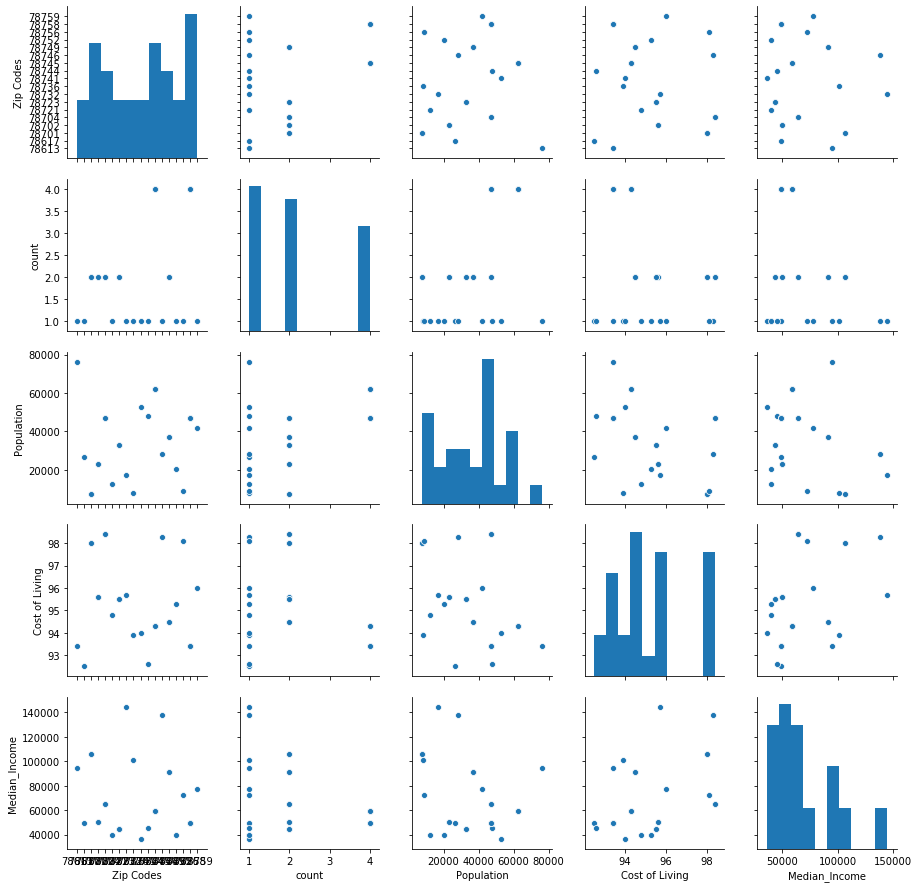

In [30]:
sns.pairplot(brewery_df)

Evaluating specific correlations to the number of breweries

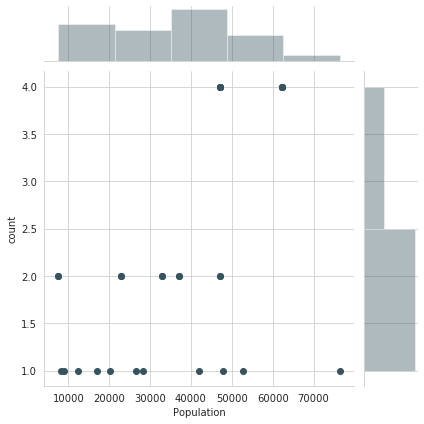

In [31]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.jointplot(x='Population',y='count',data=brewery_df)

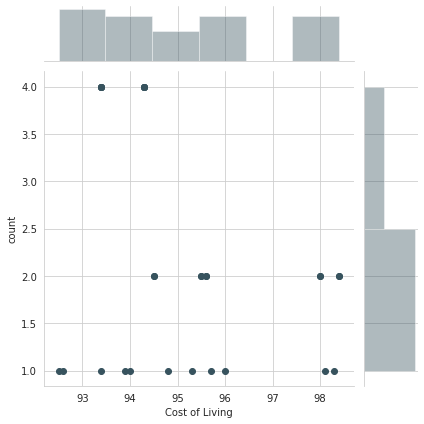

In [32]:
sns.jointplot(x='Cost of Living',y='count',data=brewery_df)

To examine other factors influencing the location of craft brewery locations, the number of wharehouse listings per zip code is evaluated.  To illustrate the difficulty, 
the wharehouse data is not readily available to be scraped and had to be manually loaded.

In [33]:
wharehouse=[78728, 78704, 78736, 78728, 78744, 78728, 78734, 78737, 78702, 73301, 78758, 78704, 78758, 78747, 78737, 78748, 78752, 78702, 78721, 78745, 78748, 78752, 78751, 78753, 78745, 78745, 78737, 78754, 78744, 78752, 78724, 78754, 78728, 78723, 78728, 78728, 78758, 78758, 78758, 78758, 78752, 78744, 78728, 78745, 78728, 78758, 78724, 78753, 78744, 78744, 78744, 78744, 78754, 78744, 78754, 78753, 78752, 78753, 78744, 78721, 78754, 78703, 78728, 78578, 78721, 78728, 78744, 78752, 78753, 78758, 78758, 78752, 78753, 78729, 78754, 78752, 78753, 78758, 78702, 78745, 78704, 78754, 78757, 78752, 78758, 78758, 78758, 78758, 78758]
whouse_df = pd.DataFrame({'Zip Codes':wharehouse})
whouse_df=whouse_df.groupby(['Zip Codes']).size().reset_index(name='Whouse')
whouse_df.head(5)

,Zip Codes,Whouse
0,73301,1
1,78578,1
2,78702,3
3,78703,1
4,78704,3


Obtain the latitude and longitude for the zip codes associated with wharehouse for lease

In [34]:
list=['78728', '78704', '78736', '78728', '78744', '78728', '78734', '78737', '78702', '73301', '78758', '78704', '78758', '78747', '78737', '78748', '78752', '78702', '78721', '78745', '78748', '78752', '78751', '78753', '78745', '78745', '78737', '78754', '78744', '78752', '78724', '78754', '78728', '78723', '78728', '78728', '78758', '78758', '78758', '78758', '78752', '78744', '78728', '78745', '78728', '78758', '78724', '78753', '78744', '78744', '78744', '78744', '78754', '78744', '78754', '78753', '78752', '78753', '78744', '78721', '78754', '78703', '78728', '78578', '78721', '78728', '78744', '78752', '78753', '78758', '78758', '78752', '78753', '78729', '78754', '78752', '78753', '78758', '78702', '78745', '78704', '78754', '78757', '78752', '78758', '78758', '78758', '78758', '78758']
list=set(list)
whouse1_lat=[]
whouse1_lon=[]
for l in list:
    address = l

    geolocator = Nominatim(user_agent="austin_explorer")
    location = geolocator.geocode(address)
    whouse_lat = location.latitude
    whouse_lon = location.longitude
    whouse1_lat.append(whouse_lat)
    whouse1_lon.append(whouse_lon)
      

Create a dataframe for the wharehouse data

In [35]:
whouse1_df = pd.DataFrame(list, columns=['Zip Codes'])
whouse1_df['Whouse_lat'] =whouse1_lat
whouse1_df['Whouse_lon'] =whouse1_lon


Generate a map of the brewery locations(Blue) and the available wharehouse locations(green)

In [36]:
venues1_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around Austin,TX

# add a red circle marker to represent Austin, TX
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Austin,TX',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues1_map)

# add the breweries as blue circle markers
for lat, lng in zip(brwery12_df.lat, brwery12_df.lng):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        #popup=name,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues1_map) 
    
# add the Wharehouse as blue circle markers
for wlat, wlng in zip(whouse1_df.Whouse_lat, whouse1_df.Whouse_lon):
    folium.features.CircleMarker(
        [wlat, wlng],
        radius=8,
        color='green',
        #popup=name,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues1_map)    


# display map
venues1_map

The location looks reasonably close to one another.  I would like to add the wharehouse data to the brewery dataframe and look for any correlation.

In [37]:
whouse_df['Zip Codes'] = whouse_df['Zip Codes'].astype(str)
brewery_df['Zip Codes'] = brewery_df['Zip Codes'].astype(str)
brewery1_df=whouse_df.merge(brewery_df, on='Zip Codes', how='inner') 
brewery1_df.head()

,Zip Codes,Whouse,count,name,Population,Cost of Living,Median_Income
0,78702,3,2,Hops & Grain,22941.0,95.6,50172.0
1,78702,3,2,The Attic at the South Austin Brewery,22941.0,95.6,50172.0
2,78704,3,2,The ABGB,47140.0,98.4,64867.0
3,78704,3,2,Uncle Billy's Brew & Que,47140.0,98.4,64867.0
4,78721,3,1,Southern Heights Brewery,12327.0,94.8,39890.0


Create a Stacked Barchart of the count of the breweries and wharehouse by Zip Code.(Only Zip codes with a brewery and wharehouse are shown)

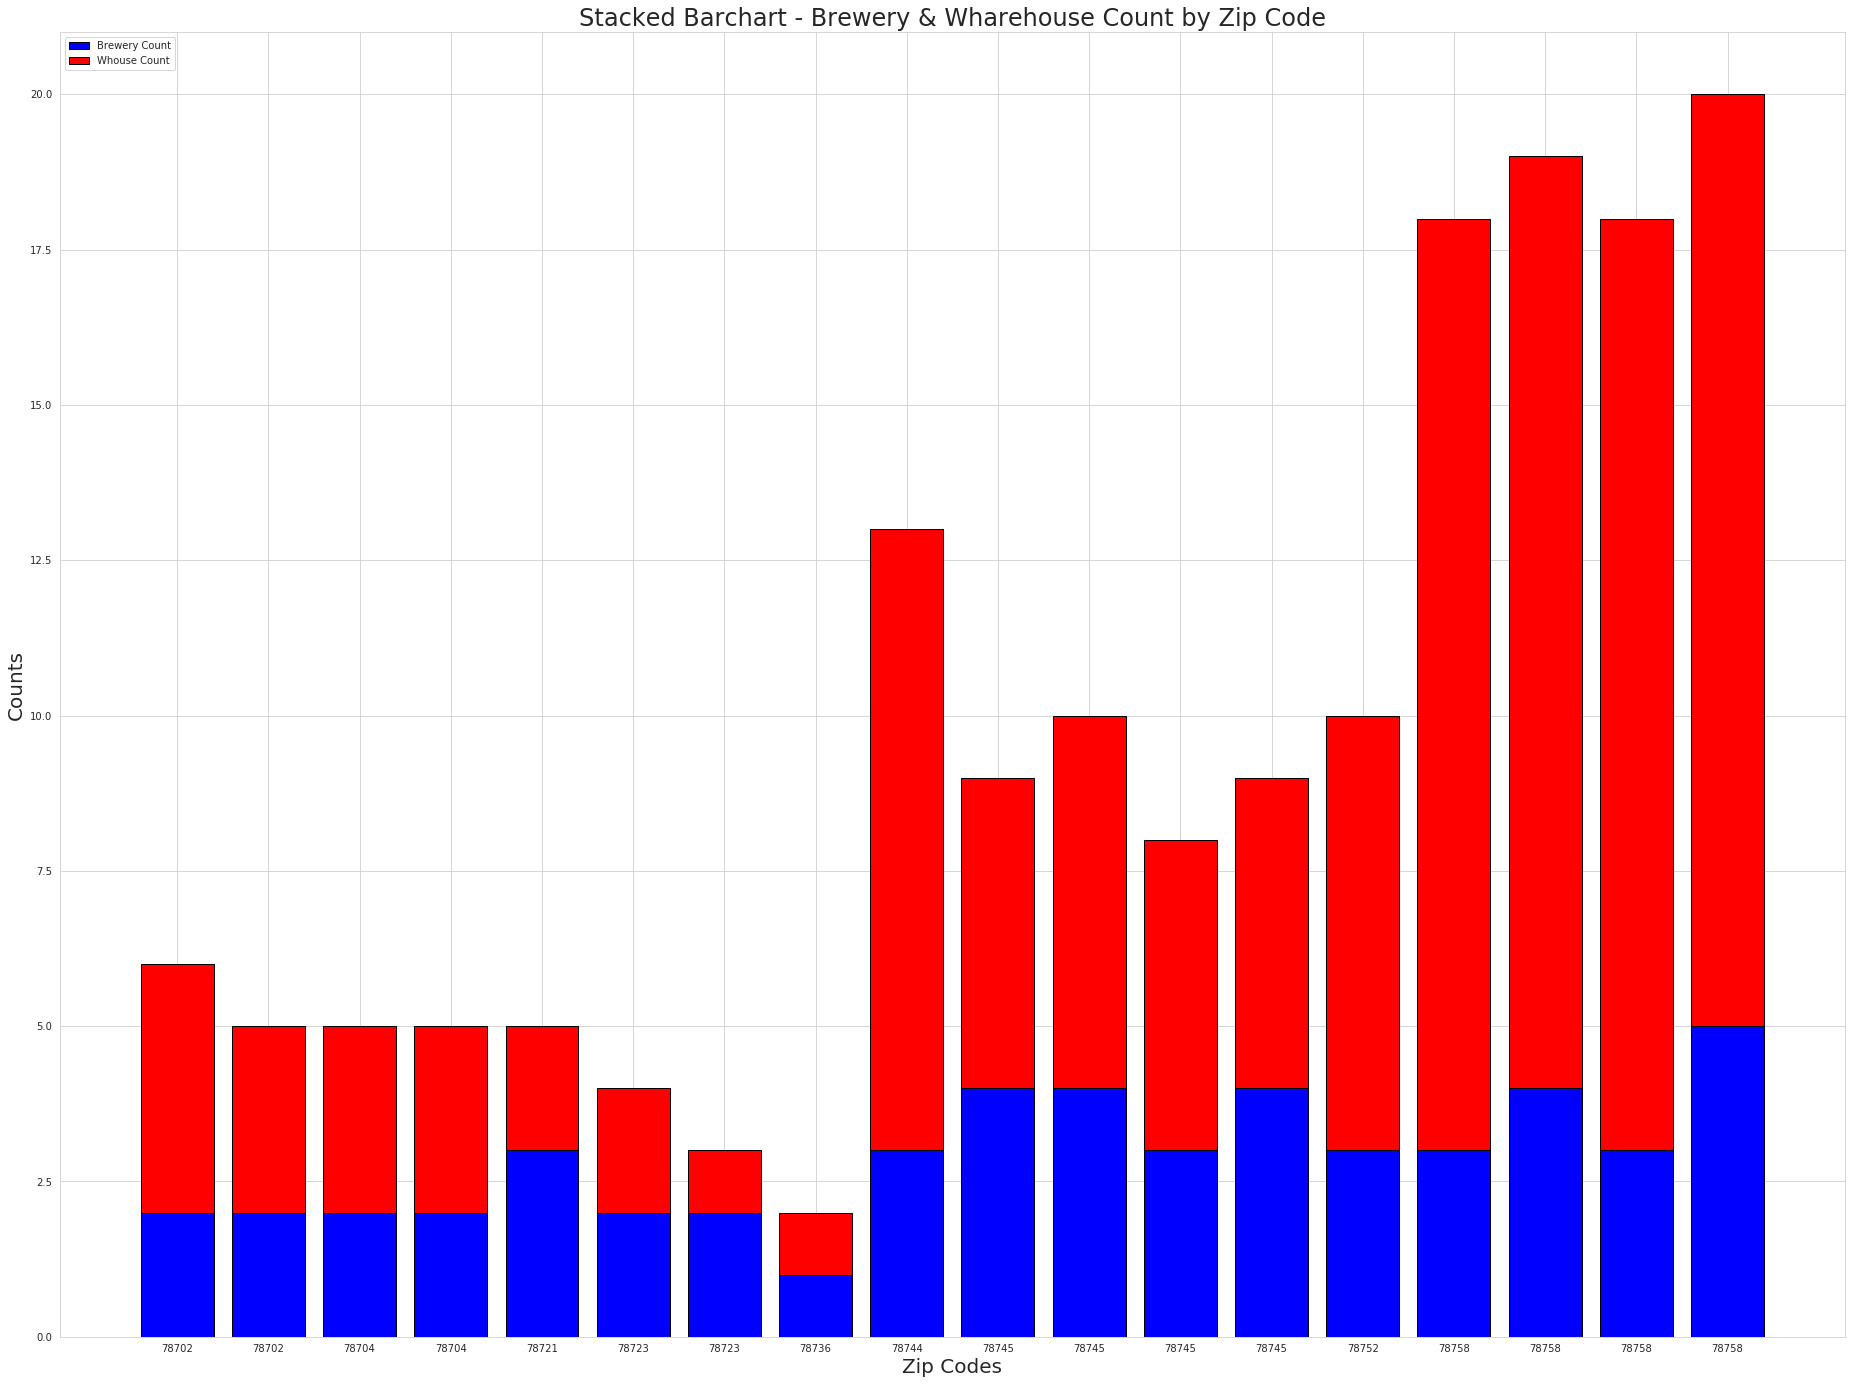

In [38]:
brewery1_df.at[13, 'count'] = 3
brewery1_df.at[8, 'count'] = 3
brewery1_df.at[4, 'count'] = 3
brewery1_df.at[11, 'count'] = 3
brewery1_df.at[16, 'count'] = 3
brewery1_df.at[17, 'count'] = 5
brewery1_df.at[4, 'Whouse'] = 2
brewery1_df.at[5, 'Whouse'] = 2
brewery1_df.at[9, 'count'] = 4
brewery1_df.at[14, 'count'] = 3
brewery1_df.at[10, 'Whouse'] = 6
brewery1_df.at[13, 'Whouse'] = 7
brewery1_df.at[0, 'count'] = 2
brewery1_df.at[0, 'Whouse'] = 4
brewery1_df.at[6, 'count'] = 2
pos = np.arange(len(brewery1_df['Zip Codes']))
Legend=['Brewery Count','Whouse Count']

plt.figure(figsize=(32,24))
plt.bar(pos,brewery1_df['count'],color='blue',edgecolor='black')
plt.bar(pos,brewery1_df['Whouse'],color='red',edgecolor='black',bottom=brewery1_df['count'])
plt.xticks(pos, brewery1_df['Zip Codes'])
plt.xlabel('Zip Codes', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.title('Stacked Barchart - Brewery & Wharehouse Count by Zip Code',fontsize=24)
plt.legend(Legend,loc=2)
plt.show()

A linear plot of the count of breweries versus the count of available wharehouses.

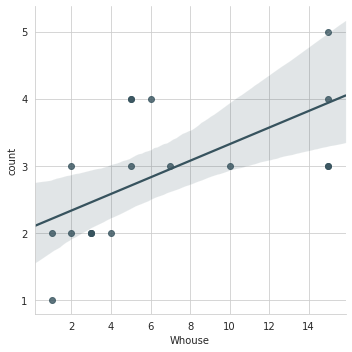

In [39]:
sns.lmplot(x='Whouse',y='count',data=brewery1_df)

In [40]:
y = brewery1_df['Whouse']

In [41]:
X = brewery1_df[['count', 'Population','Cost of Living', 'Median_Income']]

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

Create an instance of linear regression and fit the data to the model

In [43]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Predict the test set of the data

##### 

In [44]:
predictions = lm.predict( X_test)

Let's plot the predictions

Text(0, 0.5, 'Predicted Y')

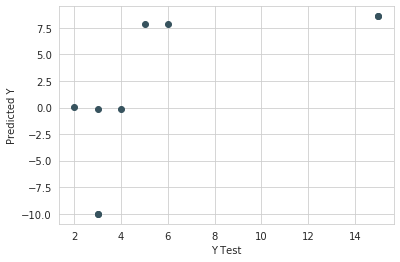

In [45]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [46]:
y1 = brewery1_df['Whouse']

In [47]:
X1 = brewery1_df[['count']]

In [48]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.5, random_state=101)

In [49]:
from sklearn.linear_model import LinearRegression
lm1 = LinearRegression()
lm1.fit(X1_train,y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
predictions1 = lm1.predict( X1_test)

Text(0, 0.5, 'Predicted Y')

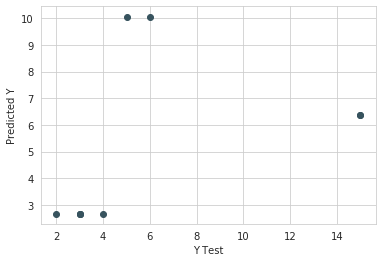

In [51]:
plt.scatter(y1_test,predictions1)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [52]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y1_test, predictions1))
print('MSE:', metrics.mean_squared_error(y1_test, predictions1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y1_test, predictions1)))

MAE: 3.2630385487528355
MSE: 21.52089407191449
RMSE: 4.6390617663396645


In [53]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 5.86028529493724
MSE: 51.377288383337685
RMSE: 7.167795224707364


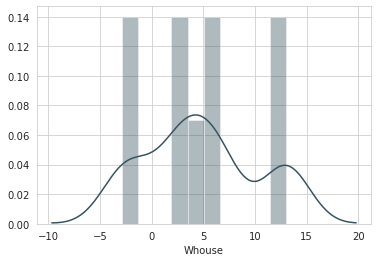

In [54]:
sns.distplot((y_test-predictions),bins=10);

In [55]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
count,2.965063
Population,-0.000039
Cost of Living,-3.002946
Median_Income,-0.000038


In [56]:
#whouse_df['Zip Codes'] = whouse_df['Zip Codes'].astype(str)
nobrew_df['Zip Codes'] = nobrew_df['Zip Codes'].astype(str)
nobrew1_df=whouse_df.merge(nobrew_df, on='Zip Codes', how='inner') 
nobrew1_df=nobrew1_df.drop(index=20)
nobrew1_df.head(5)

,Zip Codes,Whouse,Population,Cost of Living,Median_Income
0,78702,3,"22,941",95.6,"50,172"
1,78703,1,"21,113",100.7,"96,594"
2,78704,3,"47,140",98.4,"64,867"
3,78721,3,"12,327",94.8,"39,890"
4,78723,1,"32,962",95.5,"44,224"


In [57]:
max_number=nobrew1_df.iloc[[6,11],[0]]

In [58]:
print(max_number)

   Zip Codes
6      78728
11     78744


In [59]:
max=['78728', '78744']
maxwhouse1_lat=[]
maxwhouse1_lon=[]
for m in max:
    address = m

    geolocator = Nominatim(user_agent="austin_explorer")
    location = geolocator.geocode(address)
    maxwhouse_lat = location.latitude
    maxwhouse_lon = location.longitude
    maxwhouse1_lat.append(whouse_lat)
    maxwhouse1_lon.append(whouse_lon)

In [60]:
maxwhouse1_df = pd.DataFrame(max, columns=['Zip Codes'])
maxwhouse1_df['MaxWhouse_lat'] =maxwhouse1_lat
maxwhouse1_df['MaxWhouse_lon'] =maxwhouse1_lon

In [62]:
venues2_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around Austin,TX

# add a red circle marker to represent Austin, TX
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Austin,TX',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues2_map)

# add the breweries as blue circle markers
for lat, lng in zip(brwery12_df.lat, brwery12_df.lng):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        #popup=name,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues2_map) 
    
# add the Wharehouse as blue circle markers
folium.features.CircleMarker(
        [30.449171, -97.707408],
        radius=12,
        color='black',
        popup="New Brewery",
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues2_map) 

# add the Wharehouse as blue circle markers
folium.features.CircleMarker(
        [30.187599, -97.7472],
        radius=12,
        color='black',
        #popup="name",
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues2_map) 


    
for wlat, wlng in zip(whouse1_df.Whouse_lat, whouse1_df.Whouse_lon):
    folium.features.CircleMarker(
        [wlat, wlng],
        radius=8,
        color='green',
        #popup=name,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues2_map) 
    



# display map
venues2_map